In [198]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, normaltest, shapiro, kstest, anderson
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels
from sklearn.decomposition import PCA

Задание 1 и Задание 2 (подготовка данных, отбор признаков и визуализация)

In [199]:
data = pd.read_csv('/Users/Olesya/Downloads/forestfires.csv') #загружаем данные

In [200]:
#отфильтруем нулевые значения целевой переменной, так как модели с цензурированными выборками в эту работу не входят
data = data[data['area']!=0].reset_index(drop=True)
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
1,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
2,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
3,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
4,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61


In [201]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


In [202]:
# будем использовать вместо месяца время года в нашей модели, т.к. логично, что, например, зимой пожаров почти нет 
data['summer'] = ((data['month'] == 'jun')|(data['month'] == 'jul') |(data['month'] == 'aug')).apply(lambda x: int(x))
data['autumn'] = ((data['month'] == 'sep')|(data['month'] == 'oct') |(data['month'] == 'nov')).apply(lambda x: int(x))
data['winter'] = ((data['month'] == 'dec')|(data['month'] == 'jan') |(data['month'] == 'feb')).apply(lambda x: int(x))
data['spring'] = ((data['month'] == 'mar')|(data['month'] == 'apr') |(data['month'] == 'may')).apply(lambda x: int(x))

In [203]:
# также будем использовать переменную будни/выходные - в выходные пожаров больше при прочих равных из-за выездов на природу
data['workday'] = ((data['day'] == 'mon')|(data['day'] == 'tue') |(data['day'] == 'wed')|(data['day'] == 'thu')|(data['day'] == 'fri')).apply(lambda x: int(x))
data['holiday'] = ((data['day'] == 'sat')|(data['day'] == 'sun')).apply(lambda x: int(x))

In [204]:
# удалим переменные, которые не будем использовать в модели 
# площадь пожара не зависит от координат
# также удалим переменную месяца, т.к. используем вместо нее переменную сезона, и переменную дня, т.к. заменили ее тоже
del data['X']
del data['Y']
del data['day']
del data['month']

In [205]:
# удалим переменные winter и workday, чтобы не было мультиколлинеарности
del data['workday']
del data['winter']

In [206]:
# будем также использовать переменную взаимодействия температуры и ветра 
data['temp_wind'] = data['temp']*data['wind']

In [207]:
# подготовим описательные статистики (среднее, медиана, стандратное отклонение, минимум, максимум)
data.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,summer,autumn,spring,holiday,temp_wind
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185,0.462963,0.377778,0.088889,0.329630,75.706556
std,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635,0.499552,0.485732,0.285112,0.470952,37.586696
min,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,4.140000
25%,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000,0.000000,0.000000,0.000000,0.000000,46.255000
50%,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000,0.000000,0.000000,0.000000,0.000000,69.540000
75%,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500,1.000000,1.000000,0.000000,1.000000,99.837500
max,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000,1.000000,1.000000,1.000000,1.000000,213.380000


In [208]:
# выделим зависимую переменную и регрессоры в 2 отедльных датасета
Y = data['area']
X = data.copy()
del X['area']

Линейная регрессия часто делает более надежные прогнозы, если изначально масштабировать входные переменные, используя стандартизацию

In [209]:
#стандартизируем наши данные, кроме дамми-переменных, чтобы все переменные лежалим примерно в одном диапозоне
X_upd = X.copy()
del X_upd['summer']
del X_upd['spring']
del X_upd['autumn']
del X_upd['holiday']
scaler = StandardScaler()
X_tr = pd.DataFrame(scaler.fit_transform(X_upd), columns=X_upd.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [210]:
X = pd.merge(X_tr, X[['summer', 'autumn', 'spring', 'holiday']], left_index=True, right_index=True)

In [211]:
X

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,temp_wind,summer,autumn,spring,holiday
0,-1.413795,-1.076790,-1.121592,-1.274751,-0.212567,-0.115156,-0.751145,-0.072648,-0.722513,1,0,0,0
1,-0.009204,0.239853,0.530300,-0.525897,0.387304,-0.380899,-1.016949,-0.072648,-0.745436,0,1,0,0
2,-0.036215,0.191209,0.503727,-0.525897,0.419730,-0.314463,-1.229593,-0.072648,-0.967202,0,1,0,0
3,1.206308,-0.240105,-0.250777,0.971809,0.646708,-0.845950,0.205753,-0.072648,0.776806,1,0,0,0
4,-0.252306,-0.108765,-0.178898,0.802713,0.306241,0.482767,2.544835,-0.072648,3.011258,1,0,0,0
5,-0.279318,-1.028145,-1.196084,-0.115236,-0.439545,0.615639,0.684201,-0.072648,0.371390,1,0,0,1
6,1.206308,-0.240105,-0.250777,0.971809,0.727772,-0.779514,0.684201,-0.072648,1.407719,1,0,0,0
7,1.125274,0.275526,0.034558,0.295426,1.311430,-1.443873,-0.060052,-0.072648,0.903415,1,0,0,0
8,-0.252306,-1.216237,-2.109591,-0.719150,-0.990778,-0.248027,0.684201,-0.072648,-0.117988,0,0,1,0
9,-1.791954,-0.669798,0.440125,-1.443846,0.792623,-1.045258,-0.272696,-0.072648,0.304220,0,1,0,0


Итак будем использовать следующие переменные в качестве регрессоров в нашей модели:

FFMC (Указывает легкость воспламенения топлива, иными словами, вероятность возгорания) - ожидается положительный знак

DMC (Показывает влажность угля, лежащего под землей. Вероятность возгорания в результате удара молнии) - ожидается положительный знак

DC (Показывает степень увлажнения глубоких слоев органического вещества. Свидетельствует о долгосрочных условиях влажности и определяет устойчивость огня к тушению) - ожидается положительный знак

ISI (Показывает скорость распространения огня сразу после возгорания. Сочетает FFMC и скорость ветра, чтобы спрогнозировать ожидаемый темп распространения) - ожидается положительный знак

temp - ожидается положительный знак, т.к. чем выше температура, тем больше вероятность возникновения пожара	

RH - ожидается отрицательный знак, т.к. при большой влажности пожары не распространяются

wind - ожидается положительный знак, т.к. ветер способствует распространению пожаров

rain - ожидается отрицательный знак, т.к. дождь тушит пожары и пожаров меньше

temp_wind - ожидается положительный знак, т.к. при высокой температуре и сильном ветре, пожар будет распространяться очень быстро

summer - ожидается положительный знак, т.к. летом самая жаркая температура	

autumn - также ожидается положительный знак, т.к. обычно осенью тоже часто случаются пожары

spring - ожидается отрицательный знак, т.к. при рочих равных весной пожаров меньше

holiday - ожидается положительный знак, т.к. в выходные люди чаще ездят на природы и разводят костры

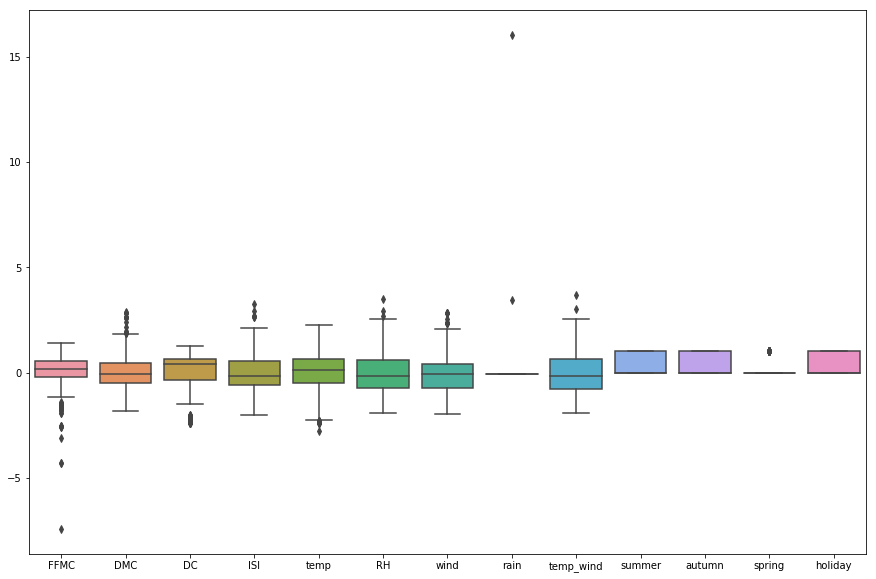

In [212]:
plt.figure(figsize=(15,10))
sns.boxplot(data=X)

Видим, что переменная rain почти всегда равна 0, а другие значения это выбросы, не будем использовать данную перменную при построении модели, также не будем использовать переменную spring по тем же причинам

In [213]:
del X['rain']

In [214]:
del X['spring']

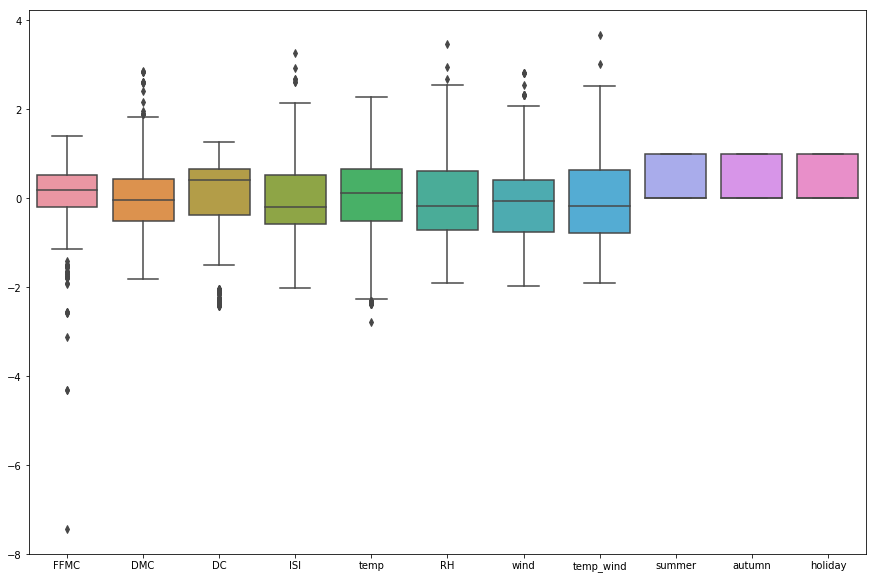

In [215]:
plt.figure(figsize=(15,10))
sns.boxplot(data=X)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


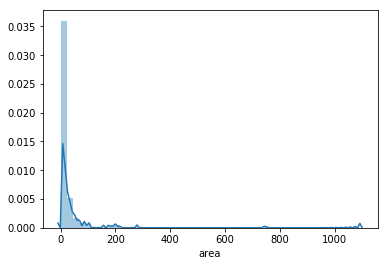

In [216]:
sns.distplot(Y)
#посмотрим на данные по зависимой переменной

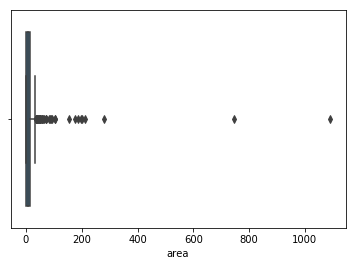

In [217]:
sns.boxplot(Y)
#посмотрим на данные по зависимой переменной

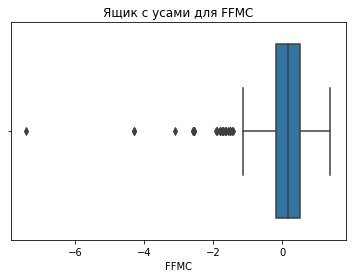

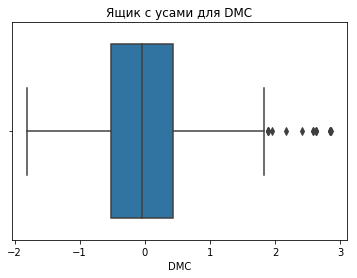

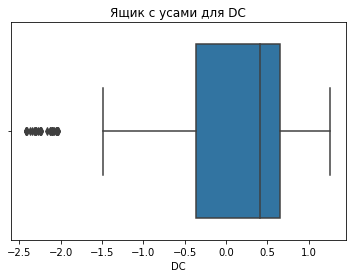

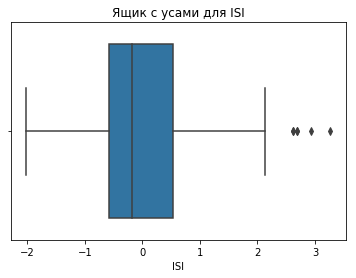

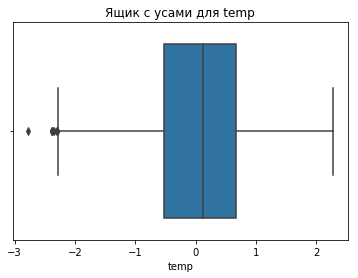

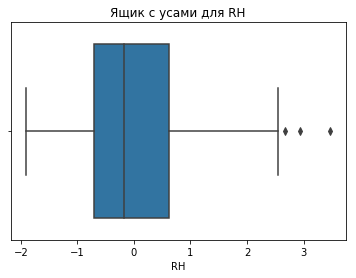

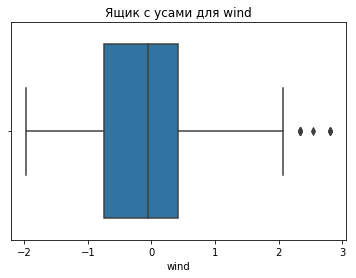

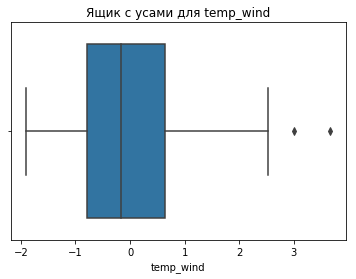

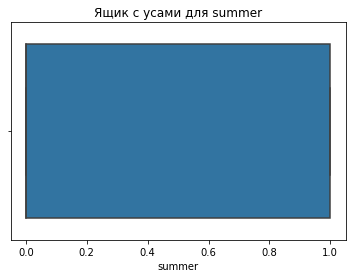

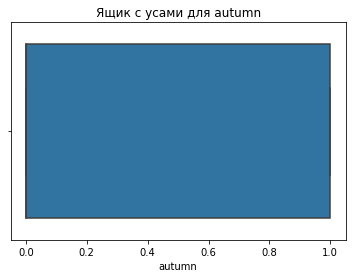

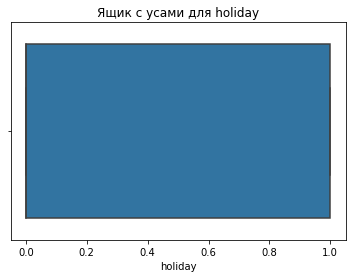

In [218]:
#Визуализруем ящик с усами для каждой переменной отдельно
for i in X.columns:
    sns.boxplot(X[i])
    plt.title(f'Ящик с усами для {i}')
    plt.show()

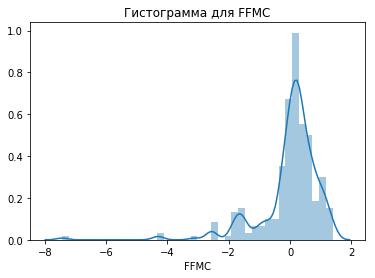

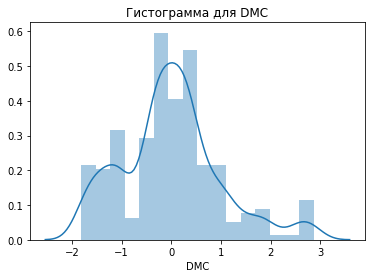

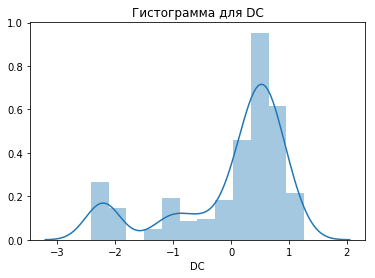

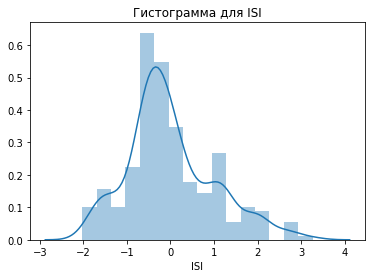

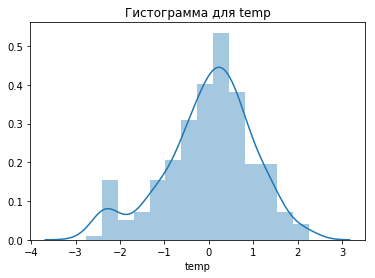

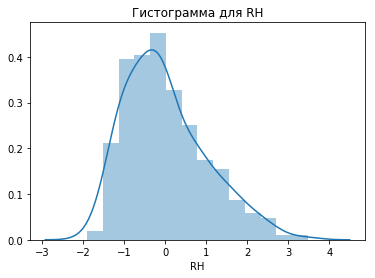

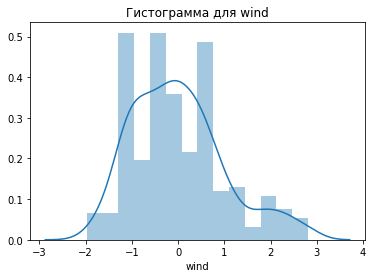

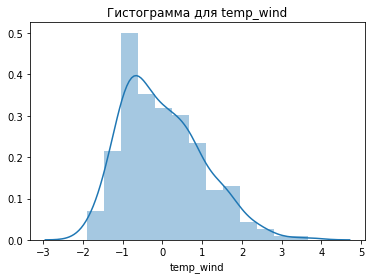

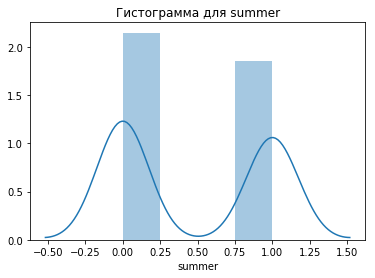

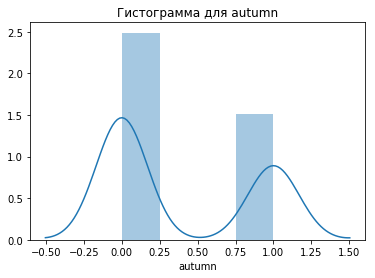

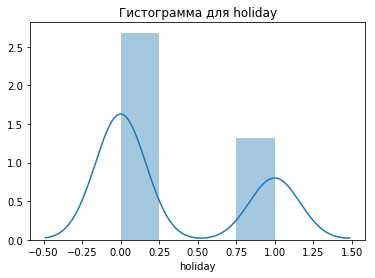

In [219]:
#посмотрим на гистограммы по каждому регрессору
for i in X.columns:
    sns.distplot(X[i])
    plt.title(f'Гистограмма для {i}')
    plt.show()

Задание 3

In [220]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.723632,FFMC
1,2.735217,DMC
2,3.554436,DC
3,2.587659,ISI
4,10.434357,temp
5,1.941259,RH
6,9.022220,wind
7,10.717817,temp_wind
8,1.738108,summer
9,2.008394,autumn


In [221]:
# видим, что VIF больше 8 только у переменных temp и wind, которые использовались для создание переменной взаимодействия
# проверим, что будет, если переменную взаимодействия удалить
del X['temp_wind']

In [222]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.712757,FFMC
1,2.729389,DMC
2,3.536247,DC
3,2.546790,ISI
4,3.141702,temp
5,1.746589,RH
6,1.284311,wind
7,1.715510,summer
8,1.990389,autumn
9,1.553323,holiday


теперь мултиколлинеарность отсутствует 

In [223]:
X['const'] = [1 for i in range(X.shape[0])] #добавим константу для построения линейной регрессии

In [224]:
norm_xtx = np.dot(X.T,X)

eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)
#CN должен быть меньше 30 -> мультиколлинеарности нет 

23.01030138796829


Задание 4

In [225]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.179
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.305
Time:                        17:30:03   Log-Likelihood:                -1580.8
No. Observations:                 270   AIC:                             3184.
Df Residuals:                     259   BIC:                             3223.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC          -0.3027      8.711     -0.035      0.9

Jarque-Bera (JB): 108065.428 - ошибки ненормальные, т.к. гипотеза о нормальности отвергается (любой тест на нормальность)

Все переменные получились незначимы, кроме индекса DMC (на 10% уровне значимости), также получился очень маленький R^2, но мы не обращаем на это внимания, т.к. такие мелочи не должны нас волновать :) Также вся модель в целом также не значима... (Prob (F-statistic):              0.305)

Итак, в итоге в регрессии было использовано 10 регрессоров и константа, посмотрим, какие знаки получились при коэффициентах:

FFMC          -0.3027 (знак не оправдался)

DMC           15.6213 (знак оправдался)

DC           -22.0577 (знак не оправдался)

ISI           -3.8709 (знак не оправдался)

temp           5.9662 (знак оправдался)

RH            -8.8560 (знак оправдался)  

wind           6.1384 (знак оправдался)  

summer        21.2294 (знак оправдался) 

autumn        50.7609 (знак оправдался) 

holiday       13.9865 (знак оправдался) 

const         -9.0150

Задание 5 (точечный прогноз и интервалы для индвидуального и среднего прогнозов)

In [226]:
y_hat_1 = model.predict(results.params)
y_hat_1

array([ 20.63652772,  35.27556276,  33.40979459,  22.48135701,
        24.60363713,  33.17890284,  25.31356564,  34.51450845,
        21.86395177,  40.01797309,   2.66825853,  30.35194264,
        23.23272996,  44.9055234 ,  25.07700374,  17.43394149,
        65.0422938 ,  -4.28748497,  62.44339139,  -0.45495337,
         8.76517702,  41.21369838,  23.6354854 ,  16.4680968 ,
        52.96751788,  31.59634195,  19.45182056,  -5.35710266,
       -12.18353631,  19.66810761,  39.62932154,   8.62773976,
        34.00614822,  -0.71455592,  36.66878297,  30.65252822,
        -1.05086194,  23.20257174,   7.01677491,  14.46012142,
        12.74496284,   2.9743415 ,  67.8633859 ,  24.63892745,
        16.98191359,   9.17853749,  19.97266912,  29.53981089,
        34.42514058,  32.07948025,  18.72717857,  19.00778409,
        15.08418578,  23.64686709,  14.80895856,  49.39031101,
        14.80895856,  23.03923404,   7.01677491,  42.73319918,
        28.75467018,  36.51563678,  38.12060875,  19.77

In [227]:
y_hat = model.predict(results.params, np.median(X,axis=0)) #точечный прогноз

In [228]:
y_hat

-16.204865104723318

In [229]:
#доверительный интервал для индивидуального прогноза

In [230]:
rss = np.sum(np.square(Y - y_hat_1))

In [231]:
rss

1925164.8114384408

In [232]:
results.centered_tss - results.ess

1925164.8114384408

In [233]:
Var_y_real = rss/259
Var_y_real

7433.06877003259

In [234]:
norm_xtx_reversed = np.linalg.inv(norm_xtx)

In [235]:
Var_y_hat = np.dot(np.dot(np.median(X,axis=0), norm_xtx_reversed),np.median(X,axis=0)) * Var_y_real
Var_y_hat

1587.8785005660452

In [236]:
CI_left = y_hat - 1.96 * (Var_y_hat + Var_y_real)**0.5

In [237]:
CI_right = y_hat + 1.96 * (Var_y_hat + Var_y_real)**0.5

In [238]:
CI_left,CI_right #интревал для индивидуального прогноза

(-202.36305330693943, 169.95332309749278)

In [239]:
#интервал для среднего
CI_left_mean = y_hat - 1.96 * (Var_y_hat)**0.5
CI_right_mean = y_hat + 1.96 * (Var_y_hat)**0.5
CI_left_mean,CI_right_mean

(-94.30732375856161, 61.89759354911498)

Задание 6 и Задание 7 (гетероскедастичность)

Температура точно должно порождать гетероскедастичность, т.к. чем выше температура, тем сильнее колебания сгоревшей площади, проверим это предположение

In [240]:
model_1 = sm.RLM(Y, X)
results_1 = model_1.fit()
print(results_1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                   area   No. Observations:                  270
Model:                            RLM   Df Residuals:                      259
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 20 Jun 2020                                         
Time:                        17:30:04                                         
No. Iterations:                    21                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.1651      1.028      0.161      0.8

При использовании робастных ошибок стандартные ошибки всех регрессоров стали сильно меньше, значит, присутствует гетероскедастичноть 


In [241]:
data['errors'] = Y - y_hat_1

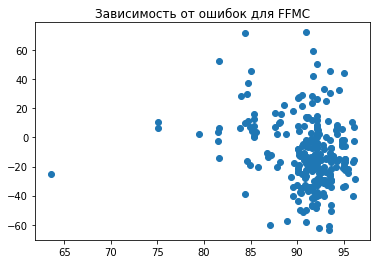

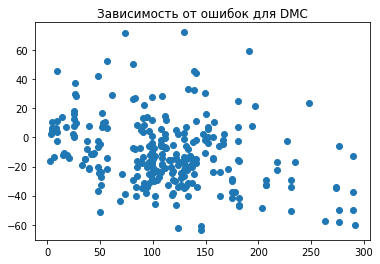

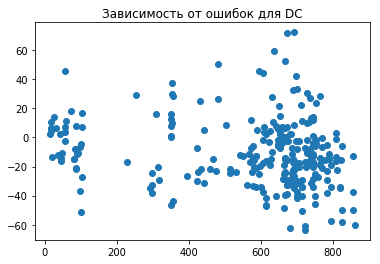

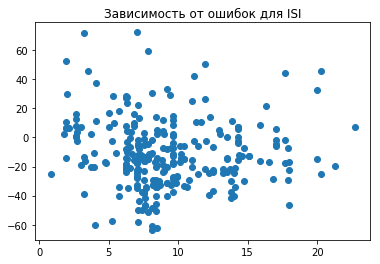

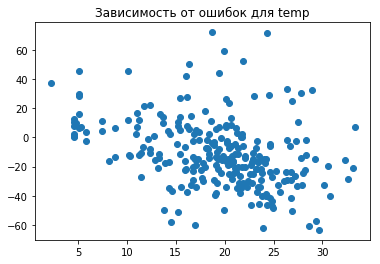

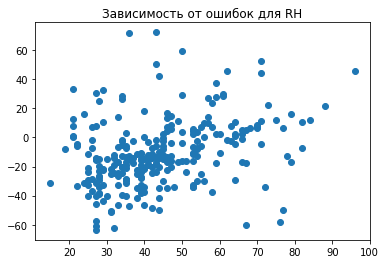

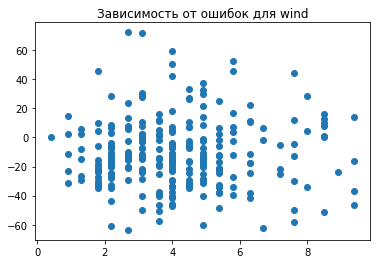

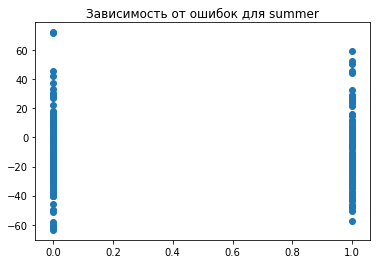

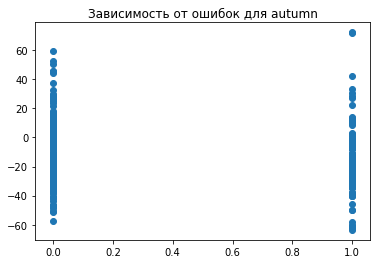

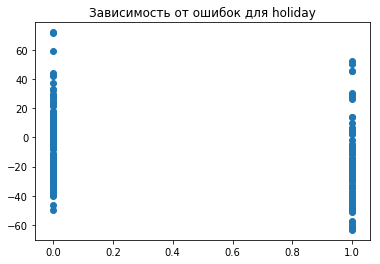

In [242]:
for i in X.columns[:-1]:
    plt.scatter(data[data['errors']**2<10000][i], data[data['errors']**2<10000]['errors'])
    plt.title(f'Зависимость от ошибок для {i}')
    plt.show()
    


По графикам видно, что стандратные ошибки непостоянные

In [243]:
for i in X.columns:
    print(i,het_goldfeldquandt(Y, X[[i]], alternative='two-sided'))

# мы видим по результатам теста гетероскедостачность по всем переменным

FFMC (0.532860391805541, 0.0003093248473901327, 'two-sided')
DMC (0.5174803731494866, 0.00016171954235805715, 'two-sided')
DC (0.5374442938607398, 0.00037220982162000074, 'two-sided')
ISI (0.5359240468572781, 0.00035019408461457307, 'two-sided')
temp (0.520178591897242, 0.00018178007748285543, 'two-sided')
RH (0.5464254745749038, 0.0005293162040182722, 'two-sided')
wind (0.5363854545611039, 0.00035674988138060837, 'two-sided')
summer (0.48447108551327595, 3.4391051166344304e-05, 'two-sided')
autumn (0.5965535840902062, 0.002996771206084057, 'two-sided')
holiday (0.5746043675442545, 0.0014683544011177333, 'two-sided')
const (0.5250730566153087, 0.0002239537664358476, 'two-sided')


Задание 8

In [244]:
np.random.seed(60)
model_WLS = sm.WLS(Y, X, weights=np.random.randint(0, 10, size=X.shape[0]))
results_WLS = model_WLS.fit()
print(results_WLS.summary())
# взвешенный МНК
# по сравнению с обычный линейной моделью теперь значимы DC, ISI, summer, autumn и holiday

                            WLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.067
Model:                            WLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.856
Date:                Sat, 20 Jun 2020   Prob (F-statistic):             0.0518
Time:                        17:30:06   Log-Likelihood:                   -inf
No. Observations:                 270   AIC:                               inf
Df Residuals:                     259   BIC:                               inf
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.9770      3.410      0.287      0.7

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:719: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


Задание 9

In [245]:
model_HC0= sm.OLS(Y, X)
results_HC0 = model_HC0.fit(cov_type = 'HC0')
results_HC0.HC0_se
print(results_HC0.summary())
# метод расчета: новая оценка стандратной ошибки для каждого коэффициента, в ней дисперсия случайной 
# ошибки заменяется на оценку HC0

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                    0.8643
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.567
Time:                        17:30:06   Log-Likelihood:                -1580.8
No. Observations:                 270   AIC:                             3184.
Df Residuals:                     259   BIC:                             3223.
Df Model:                          10                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC          -0.3027      2.842     -0.107      0.9

Итак робастные ошибки в форме Уайта (HC0)
FFMC          2.842    
DMC            7.652      
DC           9.820    
ISI            3.771    
temp          6.636  
RH           5.113    
wind              3.952     
summer        20.061     
autumn            33.413   
holiday         14.525      
const         22.948

In [246]:
model_HC3= sm.OLS(Y, X)
results_HC3 = model_HC3.fit(cov_type = 'HC3')
results_HC3.HC3_se
print(results_HC3.summary())
#бонус - применяется кроссвалидация leave-one-out (повторили для HC3)

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                    0.7891
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.639
Time:                        17:30:06   Log-Likelihood:                -1580.8
No. Observations:                 270   AIC:                             3184.
Df Residuals:                     259   BIC:                             3223.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC          -0.3027      3.761     -0.080      0.9

Ошибки HC3
FFMC        3.284     
DMC          8.239      
DC           11.663     
ISI             3.981   
temp              7.668     
RH              5.051    
wind            4.038     
summer   21.870     
autumn        31.488     
spring        15.444   
holiday      14.977     
const         22.933

Задание 10

In [247]:
pca = PCA(n_components=2)
pca.fit(X, Y)
pca.components_[:2]

array([[-0.46038797, -0.4100079 , -0.39808833, -0.37907385, -0.47309742,
         0.21483115,  0.17618919, -0.1240345 , -0.03666085, -0.00450979,
        -0.        ],
       [ 0.26369443, -0.14117538, -0.36639241,  0.54189099, -0.05554793,
        -0.0177763 ,  0.62949917,  0.15516936, -0.24202641, -0.01790034,
        -0.        ]])

In [248]:
sum(pca.explained_variance_ratio_[:2]) #доля объясненной дисперсии первыми двумя главными компонентами

0.5721766095505003

In [249]:
X_pca = pca.fit_transform(X)
model_pca = sm.OLS (Y, X_pca)
results_pca = model_pca.fit()
results_pca.summary()
#модель стала хуже, R^2 был 4.4% стал 0.8%, переменные незначимы

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.363
Time:                        17:30:06   Log-Likelihood:                -1596.4
No. Observations:                 270   AIC:                             3197.
Df Residuals:                     268   BIC:                             3204.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.2180      3.064     -1.377      0.170     -10.250       1.814
x2            -1.8526      4.930     -0.376      0.707     -11.558       7.853
==============================================================================
Omnibus:                      462.215   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118391.315
Skew:                           9.308   Prob(JB):                         0.00
Kurtosis:                     103.882   Cond. No.                         1.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Задание 11

In [250]:
#выпишем в явном виде в матричной форме функцию правдоподобия
def likelihood(beta, sigma2):
    return 1/((2*np.pi)**(X.shape[0]/2)*(sigma2**(X.shape[0]/2)) * np.exp(-((Y-X@beta).T@(Y-X@beta))/(2*sigma2)))

In [251]:
# пункт (а)
beta = np.dot(np.linalg.inv(X.T@X)@X.T, (Y))
beta
#совпадает с МНК-оценками

array([ -0.30273523,  15.62127834, -22.05767209,  -3.87090313,
         5.96615878,  -8.85597869,   6.13843304,  21.22943038,
        50.76094726,  13.98650046,  -9.01497762])